In [1]:
import sys, os, pathlib
sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[1] / 'python'))

In [2]:
#some basic imports
import sys, os, copy
import numpy as np
import datetime as dt
import pandas as pd

In [3]:
# construct a dataset with some observations and all kind of mixed lables
nObs = 10000

idx = np.array(list(range(nObs))) + 1000
c0 = np.array(np.random.choice(['A','B'], size=int(nObs*0.8)).tolist() + ['A']*int(nObs*0.2) )

c1_h = np.random.choice([12,13,14], size=nObs)
c1_d = np.random.choice([0,1], size=nObs)
c1_s = np.random.randint(60, size=nObs)

c1 = []
for i in range(nObs):
    c1.append( dt.datetime(2017,1,1,0,0,0) + dt.timedelta(days=int(c1_d[i]), hours=int(c1_h[i]), minutes=int(c1_s[i])) )

c2 = np.random.choice(['a','b','c'], size=nObs)
c3 = np.round(np.random.rand(nObs), 2)

X = pd.DataFrame({'Device': c0,
             'Time': c1,
             'Label':c2,
             'Cont':c3}, index = idx)

print(X.shape, X.columns)

(10000, 4) Index(['Cont', 'Device', 'Label', 'Time'], dtype='object')


In [4]:
class xthelper():
    j = 0
    def __int__(self):
        pass
    def __call__(self, row):
        dev_dict = {'A':0.3, 'B':0.8}
        label_dict = {'a':0.8, 'b':0.6, 'c':0.7}
        prob =  ( 0.5 + 0.1*c1_d[self.j] - (c1_h[self.j]-12)*0.5 ) * label_dict[row['Label']] + (row['Cont']-0.5)/4
        prob = max(min(1.,prob), 0.)

        self.j+=1
        if row['Device'] == 'A':
            return int(prob>0.3)
        else:
            return int(prob>0.5)
    
y= X.apply(xthelper(), axis=1)

print(y.shape, "coverage %f" % (np.sum(y)/y.shape[0]))

(10000,) coverage 0.174400


In [5]:
#split up dataset into train and (held out)test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 4) (8000,) (2000, 4) (2000,)


In [6]:
#==== PIPELINE ASSEMBLY
from Learning.Assembly import *
from Learning.GBDTreeLearner import GrowingGBClassifier
from Learning.GeneralTransformers import *

In [7]:
#assemble the pipeline by bits an pieces

#OneHot/Label encoding for feature 'Label'
tf0 = TransformerPipe([
        ('pagehistExtr', ColumnsSelect(['Label'])),
        ('labelEnc', LabelDummyTransformer())
    ])

#Extraction of Hour and Day-of-Month fromfeature  'Time'
tf1 = TransformerPipe([
        ('starttimeExtr', ColumnsSelect('Time')),
        ('hwdmyExtr', HourWeekdayDayMonthYearTransformer()),
        ('hwdselect', ColumnsSelect(['Time_hour', 'Time_day']))
    ])

#assemble a set of to use features
fu = FeatureUnion([
        ('tf0', tf0),
        ('tf1', tf1),
        ('tf2', ColumnsSelect('Cont')) # feature 'Cont' could have been wrapped into its own pipeline,
                                       # but no need to convolute as already in correct format
    ], n_jobs= 1)

#define a Classifier estimator; here one that is smarter as the average by growing additional trees
c0 = GrowingGBClassifier(ntrees_start = 100,
            ntress_increment = 10,
            est_params = {'max_depth': 3,
                          'max_features': None}, #auto
            scoring = 'log_loss',
            min_score_improvement = 1e-5,
            nrounds_noimp = 2,
            nrounds_stop = sys.maxsize,
            cv_test_frac = 0.2, 
            cv_n_splits = 3)

#as we are interested in the probabilities rather than the absolute binary calssification wrap it down once
cc0 = OneProbClassifierWrapper(c0, predictClass=1)

#this is already a complete pipeline, which uses all features except 'Device'
pred_pipe = Pipeline([
        ("fu",fu),
        ("cc0", cc0)
    ])

In [8]:
#OneHot/Label encoding for feature 'Label'

In [9]:
cf = CategoryFork(pred_pipe,
                  'Device',
                  [('A'),('B')],
                  n_jobs=1 )

main_pipe = cf

In [10]:
#train the pipeline
main_pipe.fit(X_train, y_train)

resetting estimator to null-state
call from <Learning.GBDTreeLearner.GrowingGBClassifier object at 0x000002241B35A5C0>
round n_est meter
0 100 -0.009381
1 110 -0.007752
2 120 -0.006301
3 130 -0.005176
4 140 -0.004271
5 150 -0.003431
6 160 -0.002781
7 170 -0.002279
8 180 -0.001837
9 190 -0.001512
10 200 -0.001286
11 210 -0.001070
12 220 -0.000854
13 230 -0.000670
14 240 -0.000546
15 250 -0.000439
16 260 -0.000359
17 270 -0.000288
18 280 -0.000230
19 290 -0.000195
20 300 -0.000157
21 310 -0.000137
22 320 -0.000125
23 330 -0.000119
24 340 -0.000119
no improvement for 2 rounds
With 320 estimators:: TrainScore(cv-test): -0.000125 , TrainScore(all): -0.000089
resetting estimator to null-state
call from <Learning.GBDTreeLearner.GrowingGBClassifier object at 0x000002241B35AF98>
round n_est meter
0 100 -0.002584
1 110 -0.001936
2 120 -0.001431
3 130 -0.001127
4 140 -0.000886
5 150 -0.000685
6 160 -0.000524
7 170 -0.000412
8 180 -0.000315
9 190 -0.000245
10 200 -0.000195
11 210 -0.000153
12 220 

In [11]:
# predict and verify the training by itself:
#this score is a combination of the training scores in each subpipeline in cf
y_train_pred = main_pipe.predict(X_train)
from sklearn.metrics import log_loss
log_loss(y_train, y_train_pred)

8.1884363252943598e-05

In [12]:
#measure performance on the held out data set
y_test_pred = main_pipe.predict(X_test)
from sklearn.metrics import log_loss
log_loss(y_test, y_test_pred)

0.0067202209021746994

In [13]:
from Learning.Metric import *
ClassifierOvertrainCheck(main_pipe, X_train, y_train, X_test, y_test)

RocAuc score :: train: 1.000000  test: 0.999818  diff: 1.820236e-04
LogLoss :: train: 0.000082  test: 0.006720  diff: -6.638337e-03
Adapted LogLoss :: train: -0.460920  test: -0.463154  diff: 2.233150e-03


In [14]:
#look into the category fork and have a re-analysis of the Device=='A' and =='B' predictions individually
idx_train_isA = X_train['Device']=='A'
Xp0_train = X_train.loc[ idx_train_isA ]
yp0_train = y_train.loc[ idx_train_isA ]

yp0_train_pred = cf.pipeline_list_[0].predict(Xp0_train)
log_loss(yp0_train, yp0_train_pred)

8.8724904255163409e-05

In [16]:
idx_train_isB = X_train['Device']=='B'
Xp1_train = X_train.loc[ idx_train_isB ]
yp1_train = y_train.loc[ idx_train_isB ]

yp1_train_pred = cf.pipeline_list_[1].predict(Xp1_train)
log_loss(yp1_train, yp1_train_pred)

7.1756120373687969e-05

In [17]:
#have a look at the most important features for each pipeline
fi_deep = cf.get_feature_importances_deep()
fi_deep

[('tf1__Time_hour', [0.36086802420807035, 0.42172933791702549]),
 ('tf0__Label_b', [0.054021183389564201, 0.045359401390296337]),
 ('tf1__Time_day', [0.11708919909126662, 0.10949841285235638]),
 ('tf0__Label_c', [0.11023584437471515, 0.015599217078014557]),
 ('tf0__Label_a', [0.054999398482590819, 0.066180809676820662]),
 ('tf2__Cont', [0.25591135045379265, 0.31890554835821411])]

In [18]:
fi = cf.get_feature_importances()
fi

[('tf1__Time_hour', 0.38540274129699292),
 ('tf0__Label_b', 0.050529402521109344),
 ('tf1__Time_day', 0.11402916338870595),
 ('tf0__Label_c', 0.072085453995732726),
 ('tf0__Label_a', 0.059506904870264721),
 ('tf2__Cont', 0.28130588648401256)]

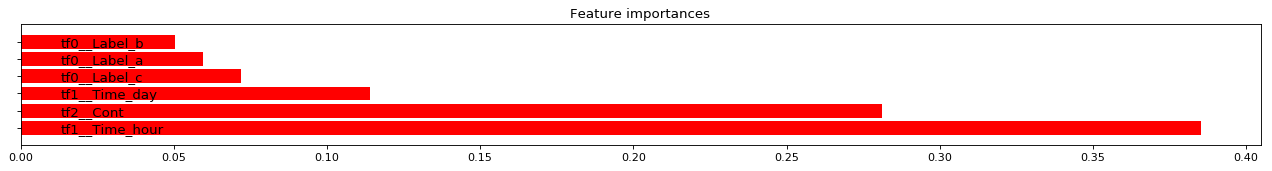

In [19]:
from Learning.Visualisation import *

plot_FeatureImportances(main_pipe)

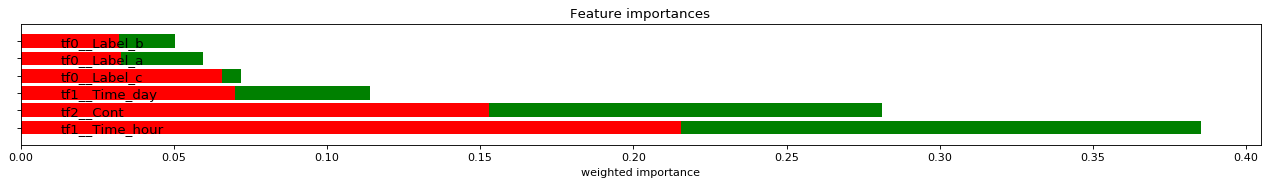

In [20]:
plot_CategoryFork_FeatureImportances(main_pipe, coverage_weighted=True)

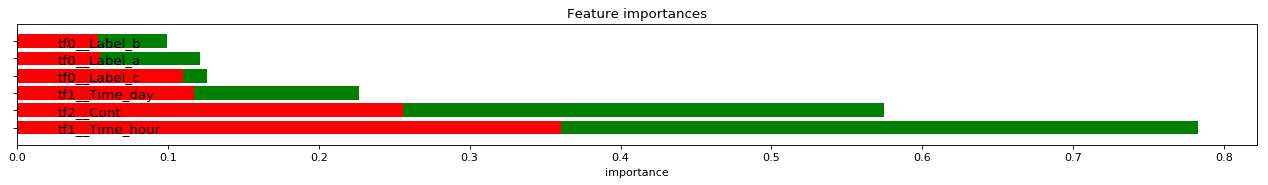

In [21]:
plot_CategoryFork_FeatureImportances(main_pipe, coverage_weighted=False)

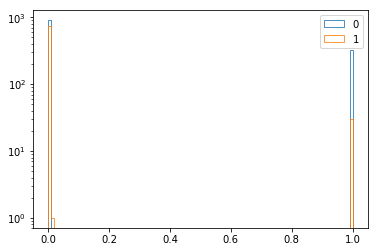

In [22]:
plot_CategoryFork_prediction(main_pipe, X_test)